<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Transfer Learning

_Author:_ Tim Book

### Learning Objectives
*After this lesson, students will be able to:*

1. Define transfer learning
1. Carry out transfer learning with and without pipelines and gridsearching
1. Identify scenarios in which transfer learning can benefit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression

## Part I: Transfer Learning from PCA
#### aka, _principal components regression (PCR)_
Often we have many columns, and too few rows. We've seen that PCA can extract only the pertinent information out of a data frame. Why don't we use that in a regression? This is the first and most common variety of transfer learning. It is also the most common thing to do with principal components beyond EDA.

In [2]:
# Santander bank data. All columns are censored - we have no idea what we're
# looking at! The target is whether or not a transaction occurs.
bank = pd.read_csv("data/bank.csv")
print(bank.shape)
bank.head()

(5000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_180481,1,8.6646,-2.0466,12.2794,7.4769,9.2845,-10.3530,5.4983,9.6363,...,5.5736,2.3082,3.9129,-4.6151,16.4741,0.6596,-2.3500,7.6949,18.3649,4.9872
1,train_8971,1,18.2832,-0.0892,10.4312,5.3875,10.3064,1.1757,5.4857,13.9550,...,3.0947,4.6538,-0.4223,4.0754,18.7514,0.7442,3.4131,9.9695,14.5161,3.5449
2,train_77027,0,13.8916,-0.3960,8.1494,5.4640,9.7626,5.9132,6.2192,20.4640,...,-4.8969,8.9005,2.7582,0.9070,23.3121,0.0969,-0.9267,9.2868,18.3342,3.0105
3,train_21656,0,8.2493,-0.0634,10.6337,8.2887,8.7866,6.1784,4.9244,21.8428,...,4.3523,4.2824,0.0808,0.4329,19.5010,-0.1478,3.6043,10.2411,18.8343,-20.5494
4,train_58303,0,9.6026,2.7460,5.8710,5.7947,8.8783,3.6953,3.3572,13.1677,...,10.7241,4.0357,3.2637,4.1165,15.9416,-0.1877,10.9384,6.6889,12.4908,-1.0994


In [7]:
xvars = bank.columns.str.startswith("var_")

In [8]:
# Let's separate into X and y
X = bank.loc[:, xvars]
y = bank["target"]

In [11]:
# How is our class imbalance?
1 - y.mean()

0.8986

In [12]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.5)

In [13]:
# Logistic regression - overfit?
model = LogisticRegression(C=1e9, solver="liblinear")
model.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [14]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9324
0.8844


In [15]:
# Let's make a pipeline that feeds PCA results into a logistic regression.
# In order to do this, we need to:
# Step 1: Scale data
# Step 2: Decompose data into PCs
# Step 3: Perform logistic regression
pipe = Pipeline([
    ("sc", StandardScaler()),
    ("pc", PCA()),
    ("lr", LogisticRegression(C=1e9, solver="lbfgs", random_state=1234))
])

In [17]:
# What are the parameters?
pipe.get_params();

In [19]:
# Let's make a gridsearcher and fit!
pgrid = {"pc__n_components": range(1, 201, 5)}
gs = GridSearchCV(
    pipe,
    param_grid=pgrid,
    cv=5,
    return_train_score=False,
    verbose=1,
    n_jobs=4
)
gs.fit(X_train, y_train);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.5s finished


In [20]:
# Best params
gs.best_params_

{'pc__n_components': 96}

In [21]:
# Best score
gs.best_score_

0.9056

In [22]:
# How about the test score?
gs.score(X_test, y_test)

0.9016

**(THREAD)**: Why did I do a train-test-split AND cross-validation here?

In [26]:
# Plot the tuning parameter curve
gs_df = pd.DataFrame(gs.cv_results_)
gs_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pc__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.040269,0.006183,0.004201,0.002725,1,{'pc__n_components': 1},0.900,0.900,0.900,0.900,0.900,0.9000,0.000000,18
1,0.051634,0.005103,0.005342,0.003449,6,{'pc__n_components': 6},0.900,0.900,0.900,0.900,0.900,0.9000,0.000000,18
2,0.056974,0.006597,0.003200,0.001722,11,{'pc__n_components': 11},0.900,0.900,0.900,0.900,0.900,0.9000,0.000000,18
3,0.058597,0.008272,0.002780,0.000946,16,{'pc__n_components': 16},0.900,0.902,0.900,0.902,0.900,0.9008,0.000980,13
4,0.059552,0.012960,0.002884,0.000430,21,{'pc__n_components': 21},0.898,0.904,0.902,0.900,0.896,0.9000,0.002828,18


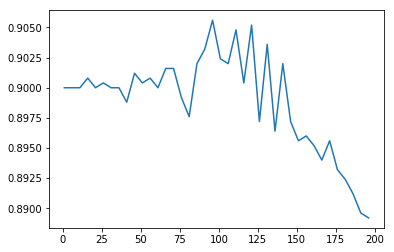

In [28]:
plt.plot(gs_df["param_pc__n_components"], gs_df["mean_test_score"]);

## Part II: Transfer Learning with Clusters
Oftentimes, we'd actually like to _add_ dimensionality to our data to give our model more information. In this example, we will use clustering to use lattitude/longitude data effectively.

It's not shown in this example, but using clustering with transfer learning is more often used as dimensionality reduction similar to PCA. Use clusters as an x-variable to replace several other variables.

In [29]:
# Some data "cleaning"
# NOTE: This shouldn't be considered best, or even good, practice.
# This is merely to get the data into a workable shape so we don't
# spend our lesson cleaning missing and categorical columns.
mel = pd.read_csv("data/melbourne.csv")
keepvars = [
    "Price", "Rooms", "Bedroom2", "Bathroom",
    "Car", "Landsize", "Lattitude", "Longtitude"
]
mel = mel[keepvars].dropna()
mel.columns = ["price", "rooms", "bed", "bath", "car", "land", "lat", "long"]
mel = mel.loc[mel["price"] < np.quantile(mel["price"], 0.99), :]
mel.head()

,price,rooms,bed,bath,car,land,lat,long
1,1480000.0,2,2.0,1.0,1.0,202.0,-37.7996,144.9984
2,1035000.0,2,2.0,1.0,0.0,156.0,-37.8079,144.9934
4,1465000.0,3,3.0,2.0,0.0,134.0,-37.8093,144.9944
5,850000.0,3,3.0,2.0,1.0,94.0,-37.7969,144.9969
6,1600000.0,4,3.0,1.0,2.0,120.0,-37.8072,144.9941


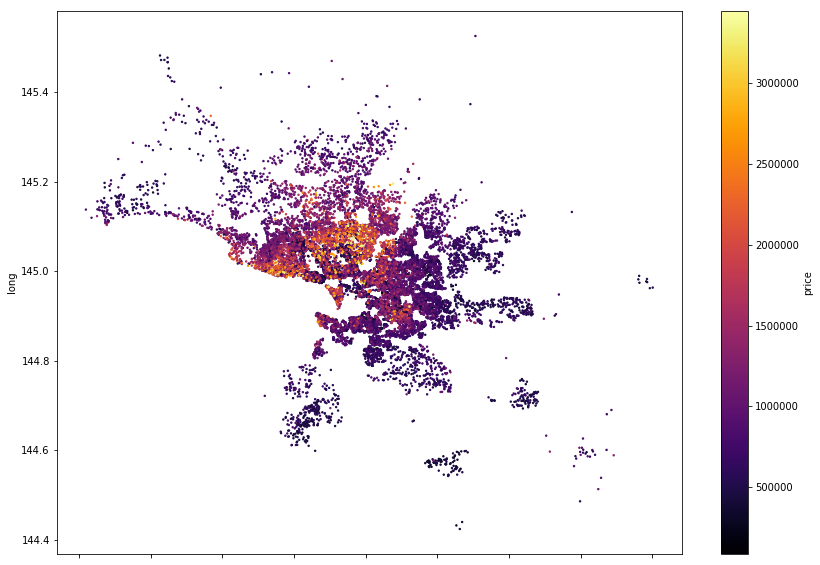

In [30]:
# Where are the highly prices houses?
mel.plot(kind="scatter", x="lat", y="long", c="price",
         cmap="inferno", figsize=(14, 10), s=2);

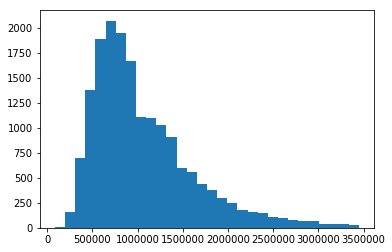

In [31]:
# Histograph of house prices - skew?
plt.hist(mel.price, bins=30);

In [32]:
mel.head(2)

,price,rooms,bed,bath,car,land,lat,long
1,1480000.0,2,2.0,1.0,1.0,202.0,-37.7996,144.9984
2,1035000.0,2,2.0,1.0,0.0,156.0,-37.8079,144.9934


In [37]:
a = [11, 22, 33, 44, 55]
b = a.copy()

In [38]:
b

[11, 22, 33, 44, 55]

In [39]:
a[2] = 99999
b

[11, 22, 33, 44, 55]

In [40]:
b[1] = 88888
a

[11, 22, 99999, 44, 55]

In [44]:
# Let's winnow our data down to only these quantitative variables.
xvars = ["rooms", "bed", "bath", "car", "land"]
X = mel.copy()[xvars]

# House prices are skew - so let's do log regression.
y = np.log(mel.copy()["price"])

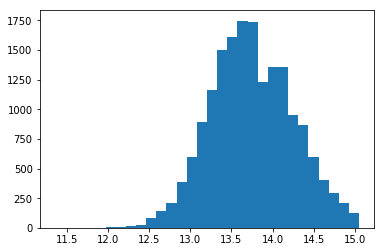

In [45]:
# Check histogram of log-price
plt.hist(y, bins=30);

In [46]:
# Let's do a train-test-split
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.5
)

In [47]:
# Carry out a linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [49]:
lr.score(X_train, y_train)

0.2564222661661999

In [48]:
# How'd it do?
lr.score(X_test, y_test)

0.2702879207663229

### The regular log-model performed kinda badly...
But as we saw in our map, home prices are not distributed uniformly about Melbourne. What if we clustered by lat/long, and used those clusters in our model?

In [50]:
# Let's scoop lat/long up in a matrix so we can use them easily
geo = mel[["long", "lat"]]
geo.head()

,long,lat
1,144.9984,-37.7996
2,144.9934,-37.8079
4,144.9944,-37.8093
5,144.9969,-37.7969
6,144.9941,-37.8072


In [51]:
# Let's cluster our observations by lat/long
km = KMeans(n_clusters=40)
km.fit(geo)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=40, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

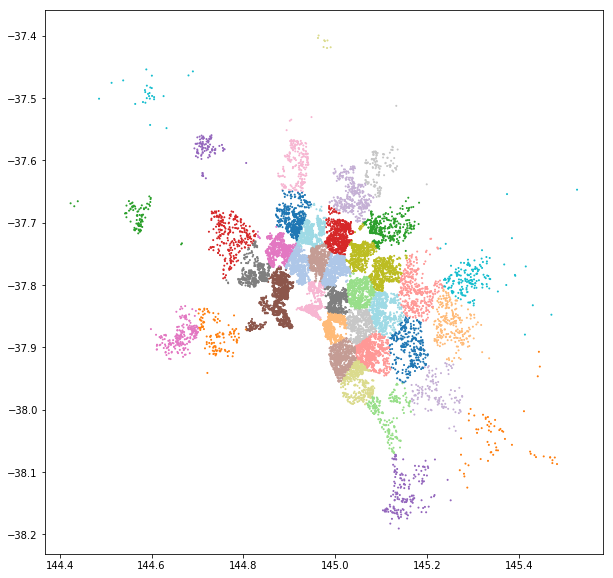

In [52]:
# What do these clusters look like visually?
plt.figure(figsize=(10, 10))
plt.scatter(mel.long, mel.lat, c=km.labels_, s=1, cmap="tab20");

In [56]:
# Neat! Now let's append these clusters back onto X
X["cluster"] = km.labels_
X = pd.get_dummies(columns=["cluster"], data=X, drop_first=True)
X.head()

,rooms,bed,bath,car,land,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,...,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37,cluster_38,cluster_39
1,2,2.0,1.0,1.0,202.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2.0,1.0,0.0,156.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,3.0,2.0,0.0,134.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3,3.0,2.0,1.0,94.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4,3.0,1.0,2.0,120.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# Train-test-split again
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.5
)

In [59]:
# How'd we do now?
lr_geo = LinearRegression()
lr_geo.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [60]:
lr_geo.score(X_test, y_test)

0.5859712629901289

In [61]:
lr_geo.score(X_train, y_train)

0.5795291934456113

### Issue #1: How do we tune $k$?
Two choices:
1. Bottle all the above into a function and iterate, finding $k$ that gives the best testing error.
2. Force this into a gridsearchable class.
    * We can't use `GridSearchCV` now because clusterers aren't _transformers_.
    * In order to fix this, we'll need some OOP skills outside the scope of today's lesson. In short, you can subclass a scikit-learn mixin and create your own class that acts like a scikit-learn transformer.

In [62]:
# All this wrapped up!
def transfer_tune(X, y, k):
    location_data = mel[["long", "lat"]]
    km = KMeans(n_clusters=k)
    km.fit(location_data)
    X.loc[:, "cluster"] = km.predict(location_data)
    X_dummy = pd.get_dummies(columns=["cluster"], data=X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.5
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    r2 = model.score(X_test, y_test)
    print(f"{k} : {r2}")

In [63]:
for k in range(2, 103, 5):
    transfer_tune(X, y, k)

2 : 0.5859244997983266
7 : 0.5935731952433845
12 : 0.5920867242570735
17 : 0.5969160366481557
22 : 0.5948849885434986
27 : 0.5915629960805376
32 : 0.5904656794214177
37 : 0.5879807011372857
42 : 0.590790224075079
47 : 0.6014155173656937
52 : 0.598478306116407
57 : 0.6069494247517477
62 : 0.6090900007947697
67 : 0.6132935491462828
72 : 0.6171977150114167
77 : 0.6147909660134279
82 : 0.6143019933975923
87 : 0.6146812903411267
92 : 0.6206210884460064
97 : 0.6222604144524104
102 : 0.6184930214799631


In [64]:
mel.shape

(17501, 8)

### Issue #2: The Train-Test-Split Dilemma
If you have many clusters, it is possible that your test data will have some clusters not represented. Using `pd.get_dummies()` won't help you here - it won't make columns for unrepresented categories.

**Example:**
Suppose you do 10-means clustering on your training data. Your training data now has labels 1 through 10. There's no guarantee that every cluster would be represented in your test data. Maybe no testing data points are put into cluster 5. When you use `pd.get_dummies()` on your testing data, it won't make a `cluster_5` column, and scikit-learn will complain about dimension mismatches (since you have one fewer column in `X_test` now).

In a production setting, you might prefer to use the `OneHotEncoder` scikit-learn class:

In [65]:
from sklearn.preprocessing import OneHotEncoder

In [66]:
km.labels_

array([ 3, 29, 29, ..., 21, 21, 21], dtype=int32)

In [67]:
oh = OneHotEncoder(categories="auto", sparse=False)
oh.fit(km.labels_.reshape(-1, 1))

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [68]:
dummy_matrix = oh.transform(km.labels_.reshape(-1, 1))

In [69]:
dummy_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
dummy_matrix.shape

(17501, 40)

In [71]:
km.labels_.shape

(17501,)

In [72]:
km.labels_.reshape(-1, 1).shape

(17501, 1)

In [73]:
A = np.random.randn(2, 3)
A

array([[-2.89130664, -0.61850432,  0.16108256],
       [-0.0223153 ,  1.3967427 ,  0.73894333]])

In [74]:
A.reshape(3, 2)

array([[-2.89130664, -0.61850432],
       [ 0.16108256, -0.0223153 ],
       [ 1.3967427 ,  0.73894333]])

In [76]:
A.reshape(-1, 1)

array([[-2.89130664],
       [-0.61850432],
       [ 0.16108256],
       [-0.0223153 ],
       [ 1.3967427 ],
       [ 0.73894333]])